In [ ]:
!pip install kaggle
from google.colab import files
files.upload() # upload kaggle.json file from Kaggle account
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d soumikrakshit/anime-faces
!unzip anime-faces.zip -d anime-faces
import os
from PIL import Image
import numpy as np
import tensorflow as tf #is the main library for implementing deep learning models
import keras #is a high-level API for building deep learning models on top of TensorFlow.
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU, Dropout #Activation Functions
from keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize #for image transformation and resizing.
from keras.utils.vis_utils import plot_model
from shutil import copyfile
from tensorflow.keras.utils import load_img, img_to_array
from tqdm import tqdm_notebook #for displaying progress bars during training.



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle (1).json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
401 - Unauthorized
Archive:  anime-faces.zip
replace anime-faces/data/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
latent_dim = 300 #pixels
height = 64
width = 64
channels = 3 #RGB

In [ ]:
generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 32 * 32)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((32, 32, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x) #Conv2D and Conv2DTranspose are classes that are used to define convolutional layers in a deep neural network
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense_2 (Dense)             (None, 131072)            39452672  
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 131072)            0         
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 256)       819456    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 256)      1048

In [ ]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 62, 62, 128)       3584      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 62, 62, 128)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 30, 30, 128)       262272    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 30, 30, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)       262272    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 14, 14, 128)       0   

In [ ]:
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

gan.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300)]             0         
                                                                 
 model_3 (Functional)        (None, 64, 64, 3)         44635907  
                                                                 
 model_4 (Functional)        (None, 1)                 795009    
                                                                 
Total params: 45,430,916
Trainable params: 44,635,907
Non-trainable params: 795,009
_________________________________________________________________


In [ ]:
from skimage.transform import rescale
list_file = os.listdir('anime-faces/data/data')

# random.shuffle(list_file)
data_train_gan = np.array([resize(imread(os.path.join('anime-faces/data/data',file_name)), (64, 64)) for file_name in list_file])

In [ ]:
x_train = data_train_gan
iterations = 5000
batch_size = 16
save_dir = '.'
start = 0

<ipython-input-17-012f14cce296>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm_notebook(range(iterations)):


  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step
discriminator loss: 0.6980355978012085
advesarial loss: 0.6498569846153259


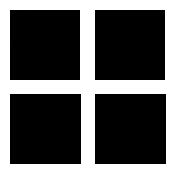

discriminator loss: 0.6980355978012085
advesarial loss: 0.6498569846153259
1/1 [==============================] - 0s 32ms/step


discriminator loss: 0.5201321840286255
advesarial loss: 1.0843455791473389


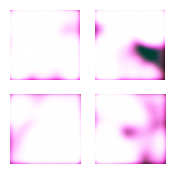

1/1 [==============================] - 0s 42ms/step


discriminator loss: 0.3869214355945587
advesarial loss: 3.3266255855560303


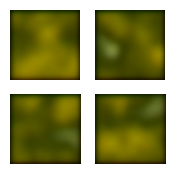

1/1 [==============================] - 0s 39ms/step
discriminator loss: 0.5259411334991455
advesarial loss: 0.9233629703521729


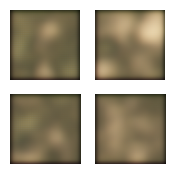

1/1 [==============================] - 0s 23ms/step


discriminator loss: 0.6246201992034912
advesarial loss: 1.0740993022918701


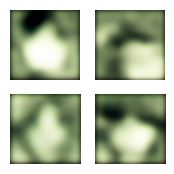

1/1 [==============================] - 0s 19ms/step
discriminator loss: 0.5905838012695312
advesarial loss: 0.8778548240661621


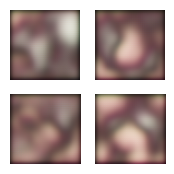

1/1 [==============================] - 0s 18ms/step


discriminator loss: 2.36663818359375
advesarial loss: 0.3471853733062744


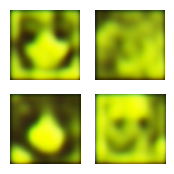

1/1 [==============================] - 0s 19ms/step


discriminator loss: 0.6482088565826416
advesarial loss: 1.2744390964508057


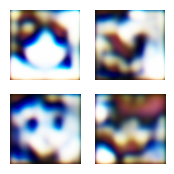

1/1 [==============================] - 0s 21ms/step


discriminator loss: 0.5376940965652466
advesarial loss: 1.2223414182662964


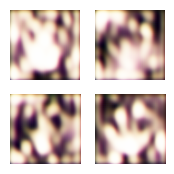

1/1 [==============================] - 0s 32ms/step


discriminator loss: 0.534875750541687
advesarial loss: 0.9060889482498169


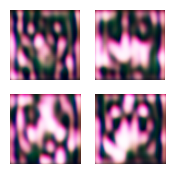

1/1 [==============================] - 0s 20ms/step


discriminator loss: 0.6485967636108398
advesarial loss: 1.468199372291565


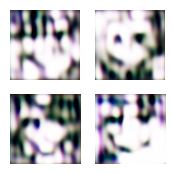

discriminator loss: 0.6485967636108398
advesarial loss: 1.468199372291565
1/1 [==============================] - 0s 20ms/step


discriminator loss: 0.6118596196174622
advesarial loss: 1.782145619392395


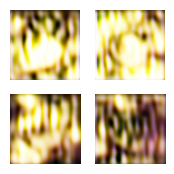

1/1 [==============================] - 0s 29ms/step


discriminator loss: 0.6775909662246704
advesarial loss: 0.7206174731254578


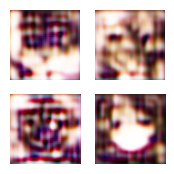

1/1 [==============================] - 0s 21ms/step


discriminator loss: 0.8171194791793823
advesarial loss: 2.204211711883545


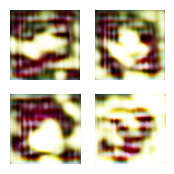

1/1 [==============================] - 0s 21ms/step


discriminator loss: 0.8629875183105469
advesarial loss: 6.745172500610352


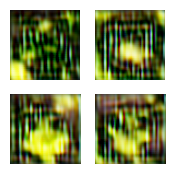

1/1 [==============================] - 0s 28ms/step


discriminator loss: 2.04461932182312
advesarial loss: 0.3321647047996521


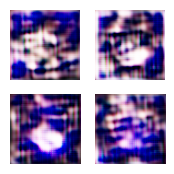

1/1 [==============================] - 0s 25ms/step


discriminator loss: 0.7072809934616089
advesarial loss: 0.6471365690231323


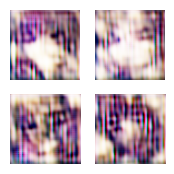

1/1 [==============================] - 0s 21ms/step


discriminator loss: 0.5863933563232422
advesarial loss: 1.481602430343628


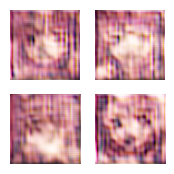

1/1 [==============================] - 0s 18ms/step


discriminator loss: 0.5385851860046387
advesarial loss: 1.1483769416809082


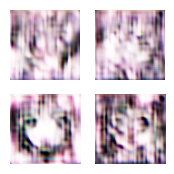

1/1 [==============================] - 0s 18ms/step


discriminator loss: 0.7069002389907837
advesarial loss: 2.001849412918091


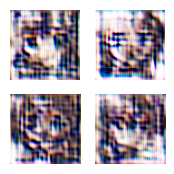

1/1 [==============================] - 0s 18ms/step


discriminator loss: 0.876751184463501
advesarial loss: 0.6229583024978638


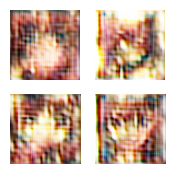

discriminator loss: 0.876751184463501
advesarial loss: 0.6229583024978638
1/1 [==============================] - 0s 20ms/step


discriminator loss: 0.7501106262207031
advesarial loss: 1.6947749853134155


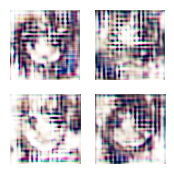

1/1 [==============================] - 0s 19ms/step


discriminator loss: 1.5621075630187988
advesarial loss: 2.9735374450683594


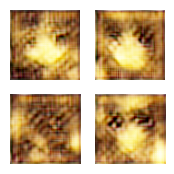

1/1 [==============================] - 0s 28ms/step


discriminator loss: 0.5633230209350586
advesarial loss: 1.4535608291625977


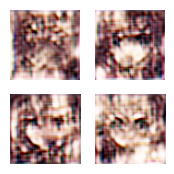

1/1 [==============================] - 0s 17ms/step


discriminator loss: 0.9498623609542847
advesarial loss: 0.8666215538978577


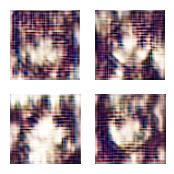

1/1 [==============================] - 0s 50ms/step
discriminator loss: 0.6004414558410645
advesarial loss: 0.5531231164932251


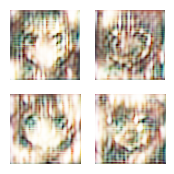

1/1 [==============================] - 0s 19ms/step


discriminator loss: 0.5349615216255188
advesarial loss: 1.5614404678344727


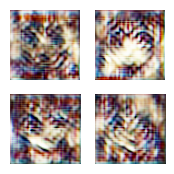

1/1 [==============================] - 0s 17ms/step


discriminator loss: 0.8805787563323975
advesarial loss: 1.4505605697631836


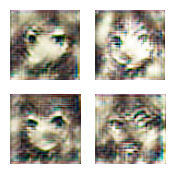

1/1 [==============================] - 0s 18ms/step


discriminator loss: 0.6590650081634521
advesarial loss: 1.123403549194336


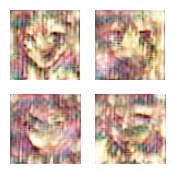

1/1 [==============================] - 0s 21ms/step


discriminator loss: 1.0419622659683228
advesarial loss: 0.8713921904563904


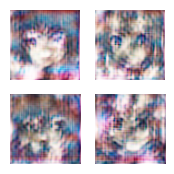

1/1 [==============================] - 0s 19ms/step


discriminator loss: 0.5966712832450867
advesarial loss: 1.339782476425171


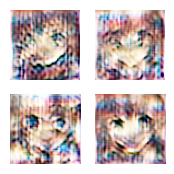

discriminator loss: 0.5966712832450867
advesarial loss: 1.339782476425171
1/1 [==============================] - 0s 26ms/step


discriminator loss: 0.5405318140983582
advesarial loss: 1.2346572875976562


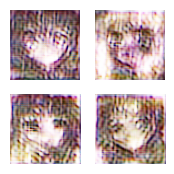

1/1 [==============================] - 0s 20ms/step


discriminator loss: 0.7343944311141968
advesarial loss: 0.6033337116241455


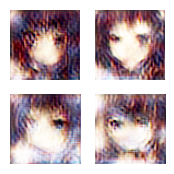

1/1 [==============================] - 0s 23ms/step


discriminator loss: 0.6928324699401855
advesarial loss: 1.329949975013733


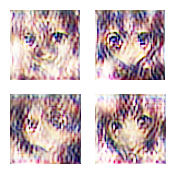

1/1 [==============================] - 0s 26ms/step


discriminator loss: 0.7015159130096436
advesarial loss: 0.6463865041732788


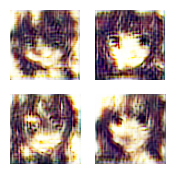

1/1 [==============================] - 0s 21ms/step


discriminator loss: 0.7199682593345642
advesarial loss: 1.9386978149414062


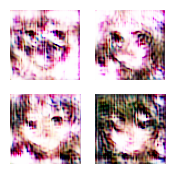

1/1 [==============================] - 0s 22ms/step


discriminator loss: 0.549157977104187
advesarial loss: 1.8554993867874146


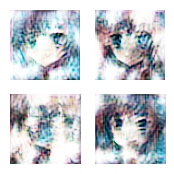

1/1 [==============================] - 0s 49ms/step


discriminator loss: 0.6246135234832764
advesarial loss: 2.9665472507476807


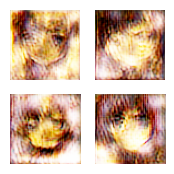

1/1 [==============================] - 0s 23ms/step


discriminator loss: 0.560070812702179
advesarial loss: 1.0488044023513794


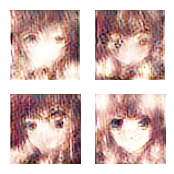

1/1 [==============================] - 0s 30ms/step


discriminator loss: 0.6061004996299744
advesarial loss: 1.3182960748672485


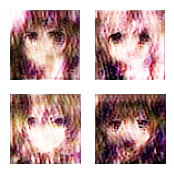

1/1 [==============================] - 0s 30ms/step


discriminator loss: 0.6488637924194336
advesarial loss: 0.8461222648620605


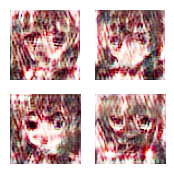

discriminator loss: 0.6488637924194336
advesarial loss: 0.8461222648620605
1/1 [==============================] - 0s 47ms/step


discriminator loss: 0.7144678831100464
advesarial loss: 1.1341068744659424


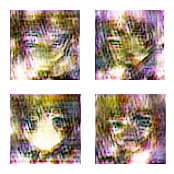

1/1 [==============================] - 0s 29ms/step


discriminator loss: 0.6679701805114746
advesarial loss: 1.1082639694213867


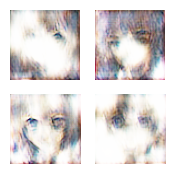

1/1 [==============================] - 0s 27ms/step


discriminator loss: 0.5540826320648193
advesarial loss: 1.6315925121307373


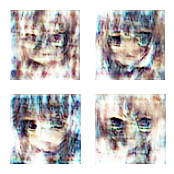

1/1 [==============================] - 0s 28ms/step


discriminator loss: 0.7721001505851746
advesarial loss: 1.0006383657455444


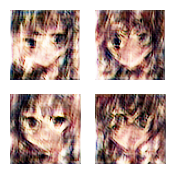

1/1 [==============================] - 0s 30ms/step


discriminator loss: 0.6732800602912903
advesarial loss: 2.1281585693359375


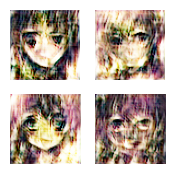

1/1 [==============================] - 0s 34ms/step


discriminator loss: 0.5760718584060669
advesarial loss: 1.2247653007507324


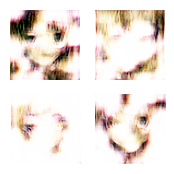

1/1 [==============================] - 0s 42ms/step


discriminator loss: 0.5923604965209961
advesarial loss: 0.7790976762771606


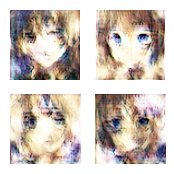

1/1 [==============================] - 0s 26ms/step


discriminator loss: 0.7199699878692627
advesarial loss: 2.8423194885253906


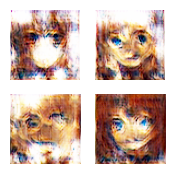

1/1 [==============================] - 0s 25ms/step


discriminator loss: 0.5531517863273621
advesarial loss: 1.7773561477661133


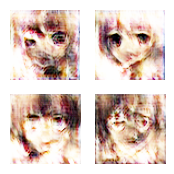

1/1 [==============================] - 0s 31ms/step


discriminator loss: 0.5993714332580566
advesarial loss: 1.4318053722381592


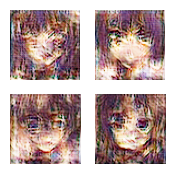

discriminator loss: 0.5993714332580566
advesarial loss: 1.4318053722381592
1/1 [==============================] - 0s 36ms/step


discriminator loss: 0.6705421209335327
advesarial loss: 0.8863431811332703


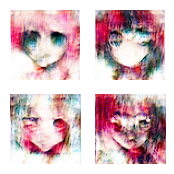

1/1 [==============================] - 0s 34ms/step


discriminator loss: 0.7144115567207336
advesarial loss: 1.784340500831604


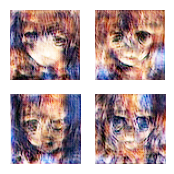

1/1 [==============================] - 0s 41ms/step


discriminator loss: 0.6518329381942749
advesarial loss: 1.0851006507873535


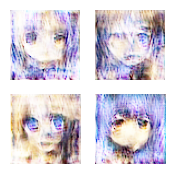

1/1 [==============================] - 0s 26ms/step


discriminator loss: 0.6640326976776123
advesarial loss: 0.6783300638198853


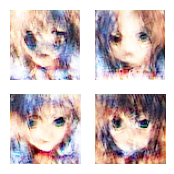

1/1 [==============================] - 0s 27ms/step


discriminator loss: 0.921800971031189
advesarial loss: 1.896453619003296


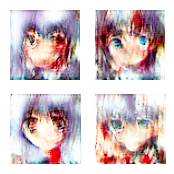

1/1 [==============================] - 0s 46ms/step


discriminator loss: 0.6712551116943359
advesarial loss: 1.2460129261016846


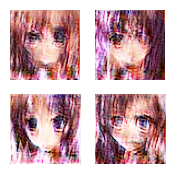

1/1 [==============================] - 0s 29ms/step


discriminator loss: 0.7052246332168579
advesarial loss: 1.0409977436065674


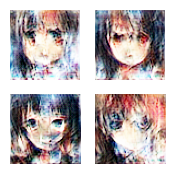

1/1 [==============================] - 0s 27ms/step


discriminator loss: 0.6064729690551758
advesarial loss: 1.2406667470932007


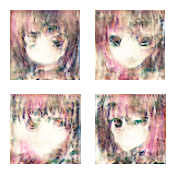

1/1 [==============================] - 0s 54ms/step


discriminator loss: 0.6691186428070068
advesarial loss: 1.1195523738861084


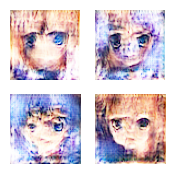

1/1 [==============================] - 0s 28ms/step


discriminator loss: 0.6189454197883606
advesarial loss: 1.0968043804168701


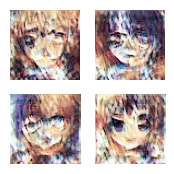

discriminator loss: 0.6189454197883606
advesarial loss: 1.0968043804168701
1/1 [==============================] - 0s 27ms/step


discriminator loss: 0.7080378532409668
advesarial loss: 0.8163026571273804


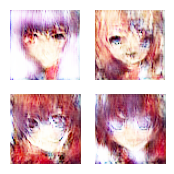

1/1 [==============================] - 0s 27ms/step


discriminator loss: 0.7666553854942322
advesarial loss: 0.7512712478637695


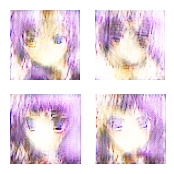

1/1 [==============================] - 0s 25ms/step


discriminator loss: 0.6963522434234619
advesarial loss: 0.8176766037940979


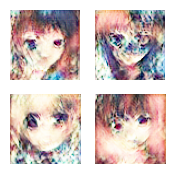

1/1 [==============================] - 0s 26ms/step


discriminator loss: 0.7070423364639282
advesarial loss: 1.2325328588485718


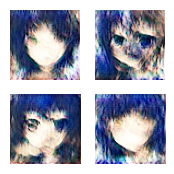

1/1 [==============================] - 0s 27ms/step


discriminator loss: 0.7332605123519897
advesarial loss: 1.028576135635376


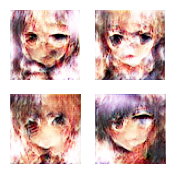

1/1 [==============================] - 0s 55ms/step


discriminator loss: 0.8253345489501953
advesarial loss: 1.6886787414550781


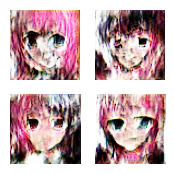

1/1 [==============================] - 0s 31ms/step


discriminator loss: 0.7521002292633057
advesarial loss: 0.7088995575904846


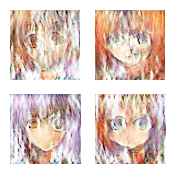

1/1 [==============================] - 0s 25ms/step


discriminator loss: 0.6957262754440308
advesarial loss: 0.7814193964004517


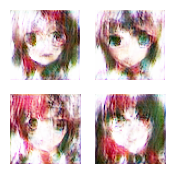

1/1 [==============================] - 0s 31ms/step


discriminator loss: 0.6602504253387451
advesarial loss: 0.9262546896934509


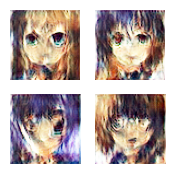

1/1 [==============================] - 0s 25ms/step
discriminator loss: 0.7741186022758484
advesarial loss: 1.5720278024673462


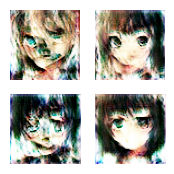

discriminator loss: 0.7741186022758484
advesarial loss: 1.5720278024673462
1/1 [==============================] - 0s 30ms/step


discriminator loss: 0.7262252569198608
advesarial loss: 0.7585784196853638


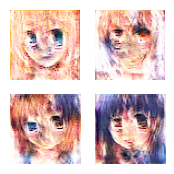

1/1 [==============================] - 0s 44ms/step


discriminator loss: 0.7014212608337402
advesarial loss: 0.5371474027633667


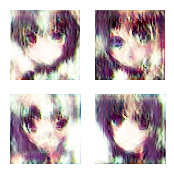

1/1 [==============================] - 0s 32ms/step


discriminator loss: 0.6915628910064697
advesarial loss: 0.7846727967262268


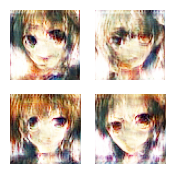

1/1 [==============================] - 0s 29ms/step


discriminator loss: 0.7175386548042297
advesarial loss: 0.8326048851013184


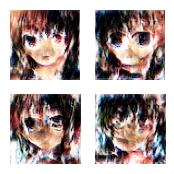

1/1 [==============================] - 0s 34ms/step


discriminator loss: 0.8115718960762024
advesarial loss: 0.8909399509429932


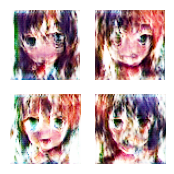

1/1 [==============================] - 0s 36ms/step


discriminator loss: 0.6712146997451782
advesarial loss: 0.733501672744751


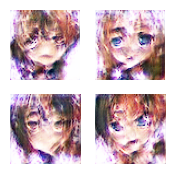

1/1 [==============================] - 0s 27ms/step


discriminator loss: 0.7442615628242493
advesarial loss: 0.7711978554725647


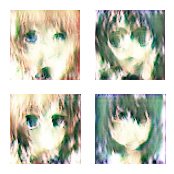

1/1 [==============================] - 0s 26ms/step


discriminator loss: 0.6685239672660828
advesarial loss: 0.9423061609268188


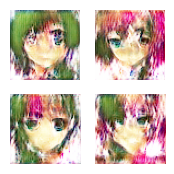

1/1 [==============================] - 0s 26ms/step


discriminator loss: 0.7356178760528564
advesarial loss: 1.1269959211349487


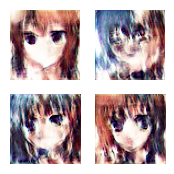

1/1 [==============================] - 0s 29ms/step


discriminator loss: 0.6490264534950256
advesarial loss: 0.7731835842132568


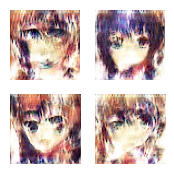

discriminator loss: 0.6490264534950256
advesarial loss: 0.7731835842132568
1/1 [==============================] - 0s 58ms/step


discriminator loss: 0.7174443006515503
advesarial loss: 1.110837459564209


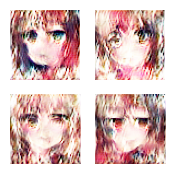

1/1 [==============================] - 0s 31ms/step


discriminator loss: 0.7158869504928589
advesarial loss: 0.658962607383728


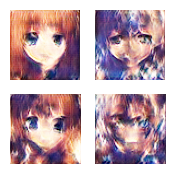

1/1 [==============================] - 0s 31ms/step


discriminator loss: 0.7116037607192993
advesarial loss: 0.9922146797180176


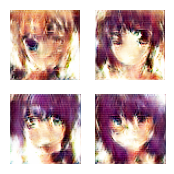

1/1 [==============================] - 0s 65ms/step
discriminator loss: 0.7208068370819092
advesarial loss: 0.7707737684249878


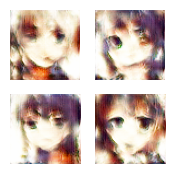

1/1 [==============================] - 0s 34ms/step


discriminator loss: 0.6652649641036987
advesarial loss: 0.8452407717704773


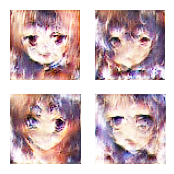

1/1 [==============================] - 0s 43ms/step


discriminator loss: 0.6716511845588684
advesarial loss: 0.8013103008270264


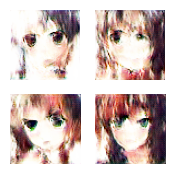

1/1 [==============================] - 0s 27ms/step


discriminator loss: 0.6963483095169067
advesarial loss: 1.0805141925811768


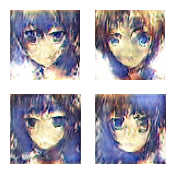

1/1 [==============================] - 0s 24ms/step


discriminator loss: 0.700377881526947
advesarial loss: 0.8950185179710388


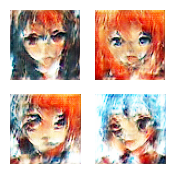

1/1 [==============================] - 0s 27ms/step


discriminator loss: 0.72590172290802
advesarial loss: 0.9042646884918213


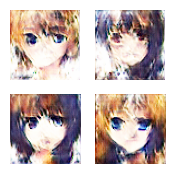

1/1 [==============================] - 0s 26ms/step
discriminator loss: 0.6907399892807007
advesarial loss: 0.851330041885376


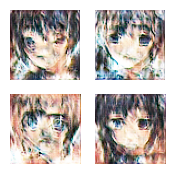

discriminator loss: 0.6907399892807007
advesarial loss: 0.851330041885376
1/1 [==============================] - 0s 30ms/step


discriminator loss: 0.6988226175308228
advesarial loss: 0.9016968011856079


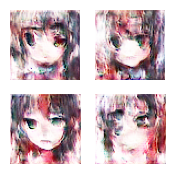

1/1 [==============================] - 0s 33ms/step


discriminator loss: 0.7336066961288452
advesarial loss: 0.7534773349761963


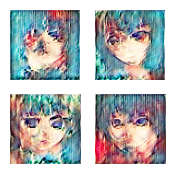

1/1 [==============================] - 0s 25ms/step


discriminator loss: 0.7406606078147888
advesarial loss: 1.0519756078720093


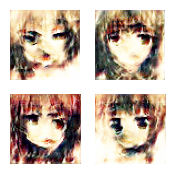

1/1 [==============================] - 0s 34ms/step


discriminator loss: 0.7136609554290771
advesarial loss: 1.004083514213562


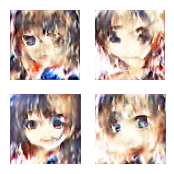

1/1 [==============================] - 0s 28ms/step


discriminator loss: 0.6787127256393433
advesarial loss: 0.7824211716651917


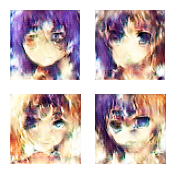

1/1 [==============================] - 0s 38ms/step


discriminator loss: 0.7000659704208374
advesarial loss: 0.5187273025512695


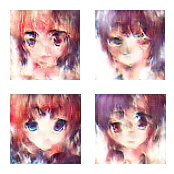

1/1 [==============================] - 0s 26ms/step


discriminator loss: 0.6730018854141235
advesarial loss: 0.7788540124893188


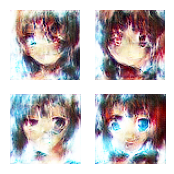

1/1 [==============================] - 0s 28ms/step
discriminator loss: 0.7121626734733582
advesarial loss: 0.8411102294921875


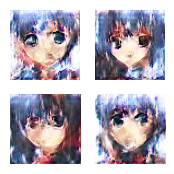

1/1 [==============================] - 0s 29ms/step


discriminator loss: 0.6707835793495178
advesarial loss: 0.7683532238006592


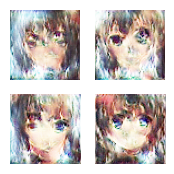

1/1 [==============================] - 0s 30ms/step


discriminator loss: 0.7024432420730591
advesarial loss: 0.8147671222686768


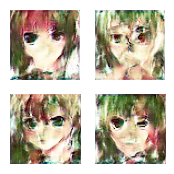

discriminator loss: 0.7024432420730591
advesarial loss: 0.8147671222686768
1/1 [==============================] - 0s 29ms/step


discriminator loss: 0.6757481098175049
advesarial loss: 0.6747974157333374


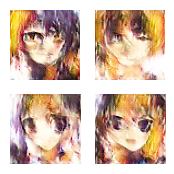

1/1 [==============================] - 0s 29ms/step


discriminator loss: 0.7888327240943909
advesarial loss: 1.215084195137024


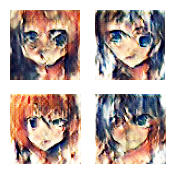

1/1 [==============================] - 0s 26ms/step


discriminator loss: 0.7026183605194092
advesarial loss: 0.9013348817825317


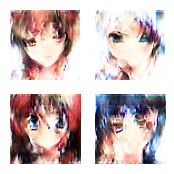

1/1 [==============================] - 0s 61ms/step


discriminator loss: 0.7143212556838989
advesarial loss: 0.7620797157287598


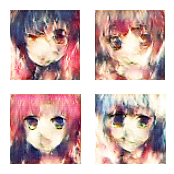

1/1 [==============================] - 0s 28ms/step


discriminator loss: 0.7147337198257446
advesarial loss: 0.8650297522544861


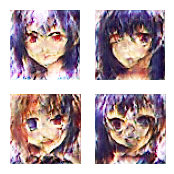

1/1 [==============================] - 0s 28ms/step


discriminator loss: 0.7495177984237671
advesarial loss: 0.9056686758995056


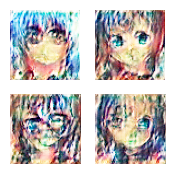

1/1 [==============================] - 0s 30ms/step


discriminator loss: 0.6920188069343567
advesarial loss: 0.8174110054969788


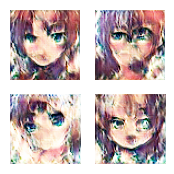

1/1 [==============================] - 0s 26ms/step


discriminator loss: 0.7426853179931641
advesarial loss: 0.7678129076957703


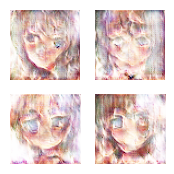

1/1 [==============================] - 0s 31ms/step


discriminator loss: 0.7180347442626953
advesarial loss: 0.9019233584403992


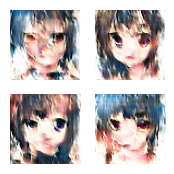

1/1 [==============================] - 0s 49ms/step


discriminator loss: 0.731706440448761
advesarial loss: 0.9896656274795532


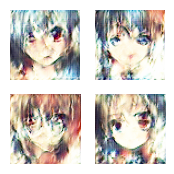

discriminator loss: 0.731706440448761
advesarial loss: 0.9896656274795532
1/1 [==============================] - 0s 39ms/step


discriminator loss: 0.70048987865448
advesarial loss: 0.7787367105484009


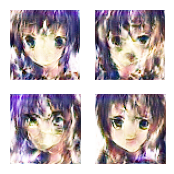

1/1 [==============================] - 0s 27ms/step


discriminator loss: 0.7095800638198853
advesarial loss: 0.8336665034294128


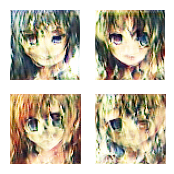

1/1 [==============================] - 0s 36ms/step


discriminator loss: 0.6503769159317017
advesarial loss: 0.7224229574203491


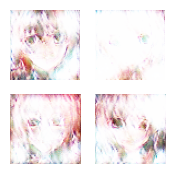

1/1 [==============================] - 0s 31ms/step


discriminator loss: 0.6762879490852356
advesarial loss: 0.7519972324371338


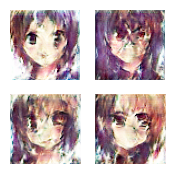

1/1 [==============================] - 0s 28ms/step


discriminator loss: 0.6955590844154358
advesarial loss: 0.8485862016677856


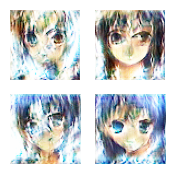

1/1 [==============================] - 0s 33ms/step


discriminator loss: 0.6995441913604736
advesarial loss: 0.6826344728469849


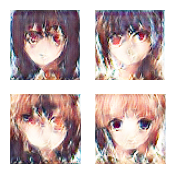

1/1 [==============================] - 0s 29ms/step


discriminator loss: 0.7046699523925781
advesarial loss: 0.7702679634094238


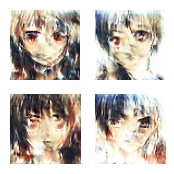

1/1 [==============================] - 0s 28ms/step


discriminator loss: 0.6877570152282715
advesarial loss: 0.7458831071853638


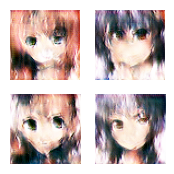

1/1 [==============================] - 0s 28ms/step


In [ ]:
# create empty lists for loss history
d_loss_history = []
a_loss_history = []

for step in tqdm_notebook(range(iterations)):
  random_latent_vectors = np.random.normal(loc=0, scale=0.4, size=(batch_size, latent_dim))
  generated_images = generator.predict(random_latent_vectors)
  stop = start + batch_size
  real_images = x_train[start: stop]
  combined_images = np.concatenate([generated_images, real_images])
  labels = np.concatenate([np.ones((batch_size,1)), 
                                    np.zeros((batch_size, 1))])
  labels += 0.05 * np.random.random(labels.shape)
  
  d_loss = discriminator.train_on_batch(combined_images, labels)
  d_loss_history.append(d_loss)
  
  random_latent_vectors = np.random.normal(loc=0, scale=0.4, size=(batch_size, 
                                                 latent_dim))
  misleading_targets = np.zeros((batch_size, 1))
  a_loss = gan.train_on_batch(random_latent_vectors, 
                              misleading_targets)
  a_loss_history.append(a_loss)
  
  start += batch_size
  
  if start > len(x_train) - batch_size:
    start = 0
 
  if step % 10 == 0:
    print('discriminator loss:', d_loss)
    print('advesarial loss:', a_loss)
    fig, axes = plt.subplots(2, 2)
    fig.set_size_inches(2,2)
    count = 0
    for i in range(2):
      for j in range(2):
        axes[i, j].imshow(resize(generated_images[count], (64,64)))
        axes[i, j].axis('off')
        count += 1
    plt.show()
 
  if step % 100 == 0:
    gan.save_weights('model.h5')
    
    print('discriminator loss:', d_loss)
    print('advesarial loss:', a_loss)




In [ ]:
# plot the losses
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(d_loss_history, label='Discriminator loss')
ax.plot(a_loss_history, label='Adversarial loss')
ax.legend()
plt.show()